# 0.0 Imports

In [1]:
import math
import random
import pickle
import datetime
import inflection
import numpy    as np
import pandas   as pd
import xgboost  as xgb
import seaborn  as sns
import datetime as dt

import matplotlib.gridspec  as gridspec
import matplotlib.pyplot    as plt
from IPython.core.display   import HTML
from IPython.display        import Image

from boruta                 import BorutaPy
from scipy                  import stats as ss
from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble       import RandomForestRegressor
from sklearn.metrics        import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from tabulate               import tabulate

## 0.1. Helper Functions

In [2]:
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold +1)):
        
        if verbose:
            print('\nKFold Number: {}'.format( k ))
        #Start and End Date for Validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*7*6)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*7*6)

        #Filtering DataSet
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #Training and Validation DataSet
        #Training
        xtraining = training.drop (['date', 'sales'], axis = 1)
        ytraining = training['sales']

        #Validation
        xvalidation = validation.drop (['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        #Model
        m = model.fit(xtraining, ytraining)

        #Prediction
        yhat = m.predict(xvalidation)

        #Performance
        m_result = ml_error( model_name, np.expm1(yvalidation), np.expm1(yhat))

        #Store Performance of Each Kfold Iteration
        mae_list.append( m_result['MAE'])
        mape_list.append( m_result['MAPE'])
        rmse_list.append (m_result ['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index =[0])

def mean_percentage_error( y, yhat ):
    return np.mean( ( ( y - yhat ) / y ) )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt( mean_squared_error (y,yhat))
    
    return pd.DataFrame ( { 'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse}, index = [0])
def cramer_v (x,y):

    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k -1)**2/(n-1)
    rcorr = k - (r -1)**2/(n-1)
    
    return np.sqrt((chi2/n)/(min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\marin\.conda\envs\Projeto01\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv( 'train.csv', low_memory = False )
df_store_raw = pd.read_csv( 'store.csv', low_memory = False )

# Merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how = "left", on = "Store")

# 1.0 Data Description

### 1.1.  Rename  Columns

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore ( x )

cols_new = list( map( snakecase, cols_old ) )

# rename

df1.columns = cols_new

### 1.2. Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0]) )
print( 'Number of Cols: {}'.format( df1.shape[1]) )

Number of Rows: 1017209
Number of Cols: 18


### 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [11]:
#competition_distance

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis = 1)

#promo2_since_week

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis = 1)

#promo2_since_year

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis = 1)

#promo_interval

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr' , 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Out', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0, axis =1)

In [12]:
df1.sample(5).T

,224400,39557,461792,241631,503487
store,286,533,968,692,293
day_of_week,7,5,3,5,7
date,2015-01-11 00:00:00,2015-06-26 00:00:00,2014-05-14 00:00:00,2014-12-26 00:00:00,2014-04-06 00:00:00
sales,0,8950,6627,0,0
customers,0,991,821,0,0
open,0,1,1,0,0
promo,0,0,0,0,0
state_holiday,0,0,0,c,0
school_holiday,0,0,0,1,0
store_type,a,a,c,a,c


In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6. Change Types

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

### 1.7. Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes (include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes (exclude = ['int64', 'float64',  'datetime64[ns]'])

#### 1.7.1. Numerical Attributes

In [18]:
#Central Tendency = Mean, Median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion = Std, Min, Max, Range, skew, Kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

#Concatenate

m = pd.concat((d2 , d3 , d4 , ct1 , ct2 , d1 , d5 , d6)).T.reset_index()
m.columns =['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#### 1.7.2. Categorical Attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

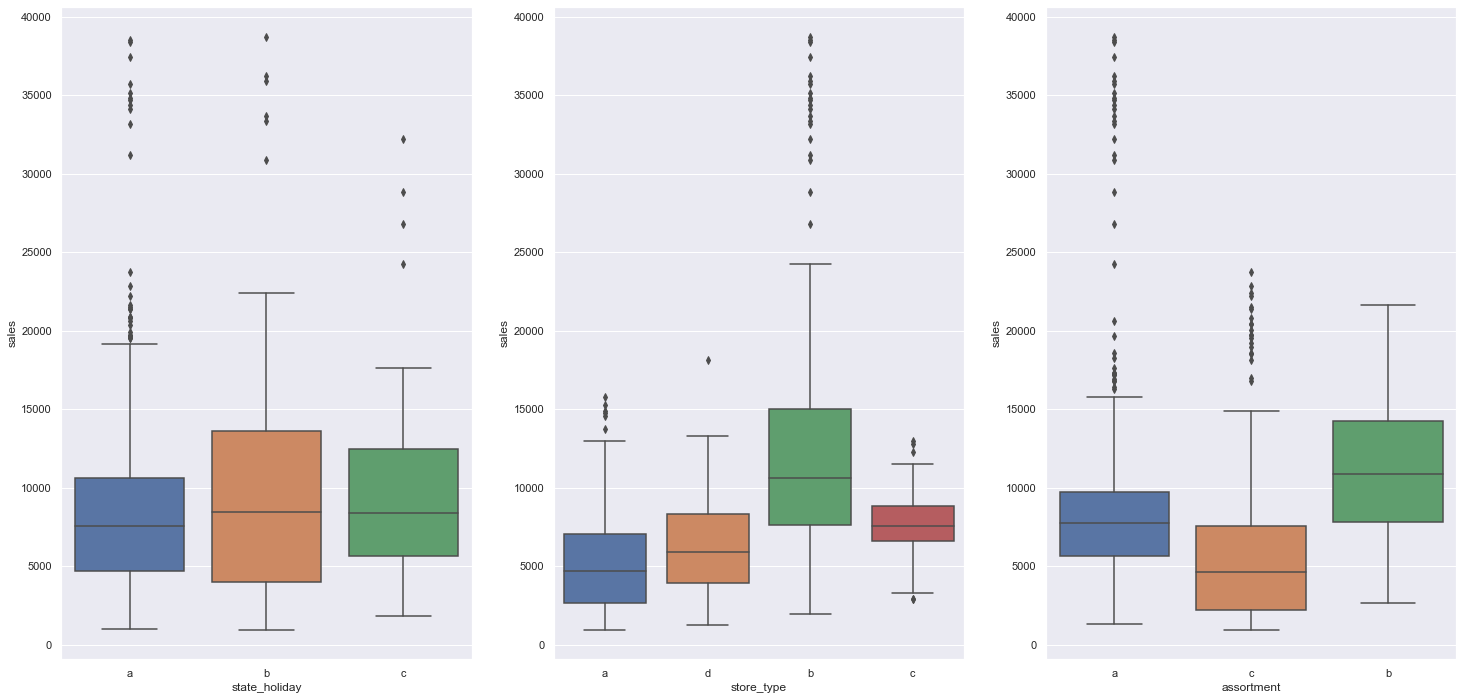

In [20]:
data_graph = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot (1, 3, 1)
sns.boxplot ( x = 'state_holiday', y = 'sales', data = data_graph)

plt.subplot (1, 3, 2)
sns.boxplot ( x = 'store_type', y = 'sales', data = data_graph)

plt.subplot (1, 3, 3)
sns.boxplot ( x = 'assortment', y = 'sales', data = data_graph)


## 2.0 Feature Engineering

In [21]:
df2 = df1.copy()

### 2.0. Feature Engineering

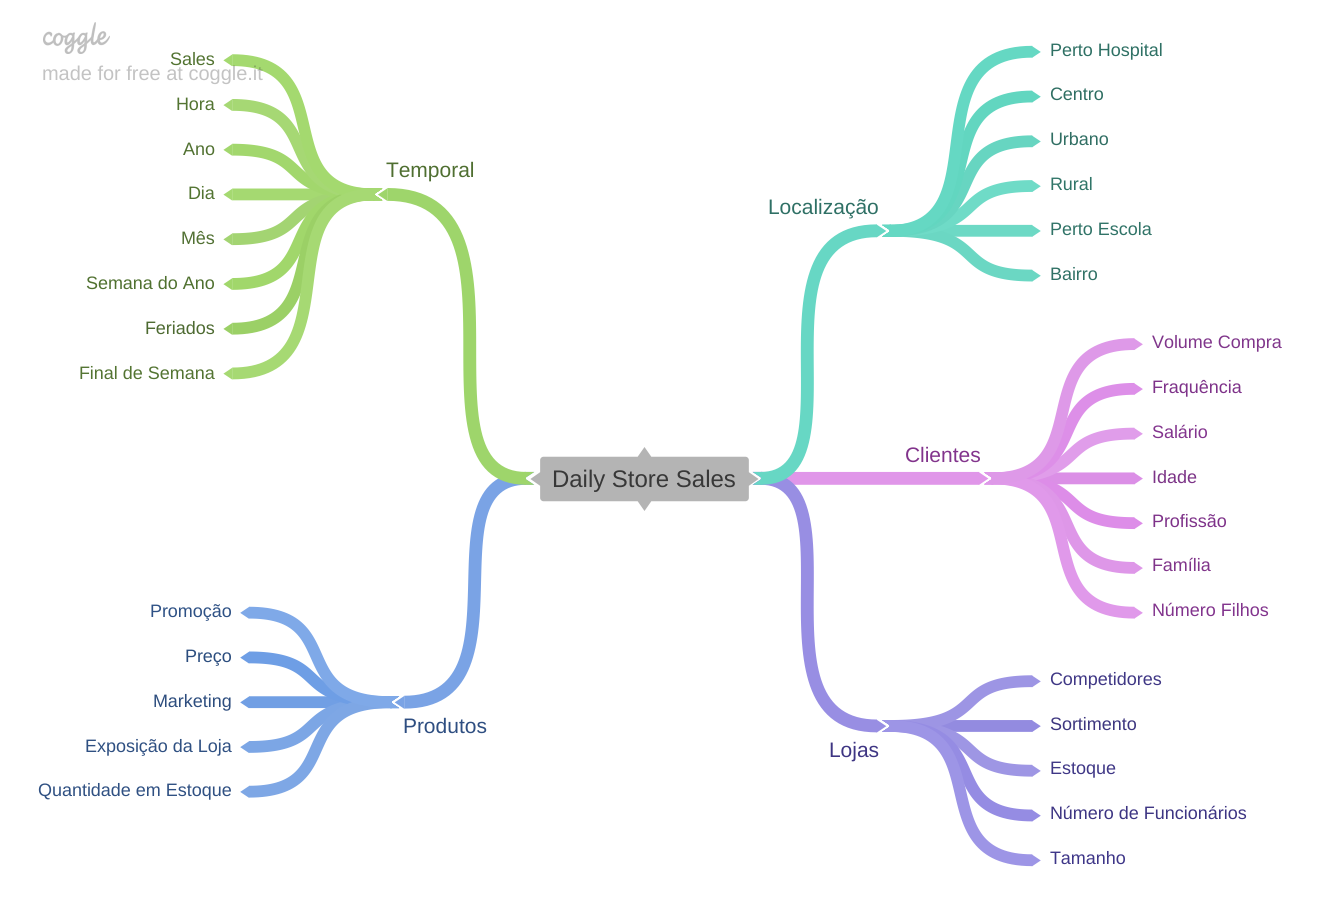

In [22]:
Image ( 'Mind_Map_Hypotesis.png' )

### 2.1. Criação de Hipóteses

#### 2.1.1. Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender mais.

**7.** Lojas com competidores há mais tempo deveriam vender mais.

#### 2.1.1. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoem mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo no(s) x(s) produto deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.


#### 2.1.1. Hipóteses Tempo (Sazonalidade)

**1.** Lojas que abrem no feriado do Natal deveriam vender mais.

**2.** Lojas que abrem no segundo semestre deveriam vender mais.

**3.** Lojas que abrem nos finais de semanas deveriam vender menos.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos durante os feriados escolares.

**6.** Lojas deveriam vender mais no decorrer dos anos.

### 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas que promoções ativas por mais tempo no(s) x(s) produto deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas que abrem no feriado do Natal deveriam vender mais.

**8.** Lojas deveriam vender mais no decorrer dos anos.

**9.** Lojas que abrem no segundo semestre deveriam vender mais.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas que abrem nos finais de semanas deveriam vender menos.

**12.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3. Feature Engineering

In [23]:
#Year
df2['year'] = df2['date'].dt.year

#Month
df2['month'] = df2['date'].dt.month

#Day
df2['day'] = df2['date'].dt.day

#Week of Year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#Year Week
df2['year_week'] = df2['date'].dt.strftime ('%Y-%W')

#Competition Since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime (year= x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply (lambda x: x.days).astype('int64')

#Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since']  = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta (days = 7 ))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype('int64')

#Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

#State Holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'Public Holiday' if x == 'a' else 'Easter Holiday' if x == 'b' else 'Christmas' if  x == 'c' else 'Regular Day')

### 3.0. Filter (VAR)

In [24]:
df3 = df2.copy()

#### 3.1. Filter (Observation)

In [25]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

#### 3.2. Filter (Features)

In [26]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis = 1)

### 4.0. E.D.A 

In [27]:
df4 = df3.copy()

#### 4.1. Univariate Analysis

#### 4.1.1 Response Variable

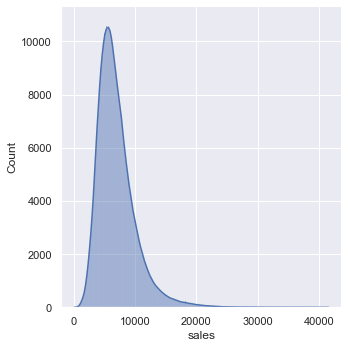

In [28]:
sns.displot(df4['sales'], kde = True)

#### 4.1.2 Numerical Variable

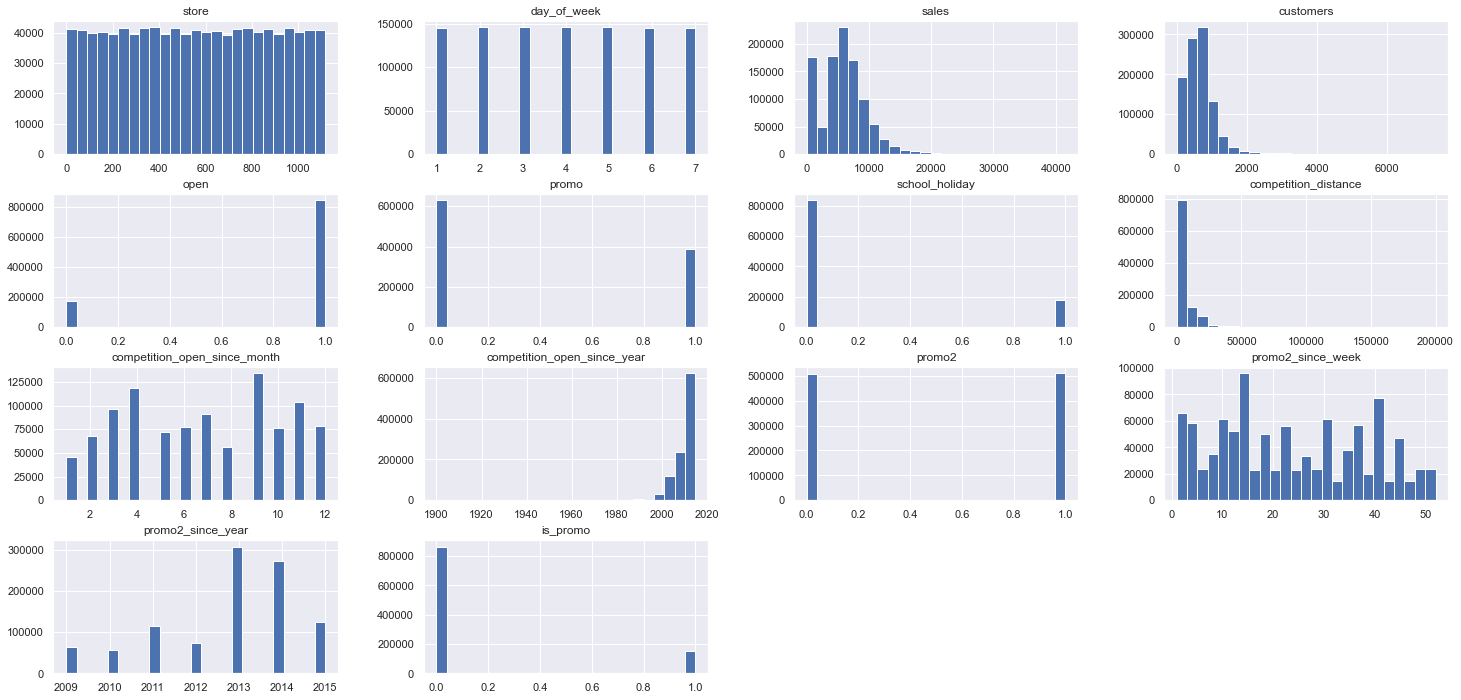

In [29]:
num_attributes.hist(bins = 25);

#### 4.1.3 Categorical Variable

In [30]:
df4['state_holiday'].drop_duplicates()

0            Regular Day
63559     Public Holiday
129424    Easter Holiday
241126         Christmas
Name: state_holiday, dtype: object

In [31]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [32]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

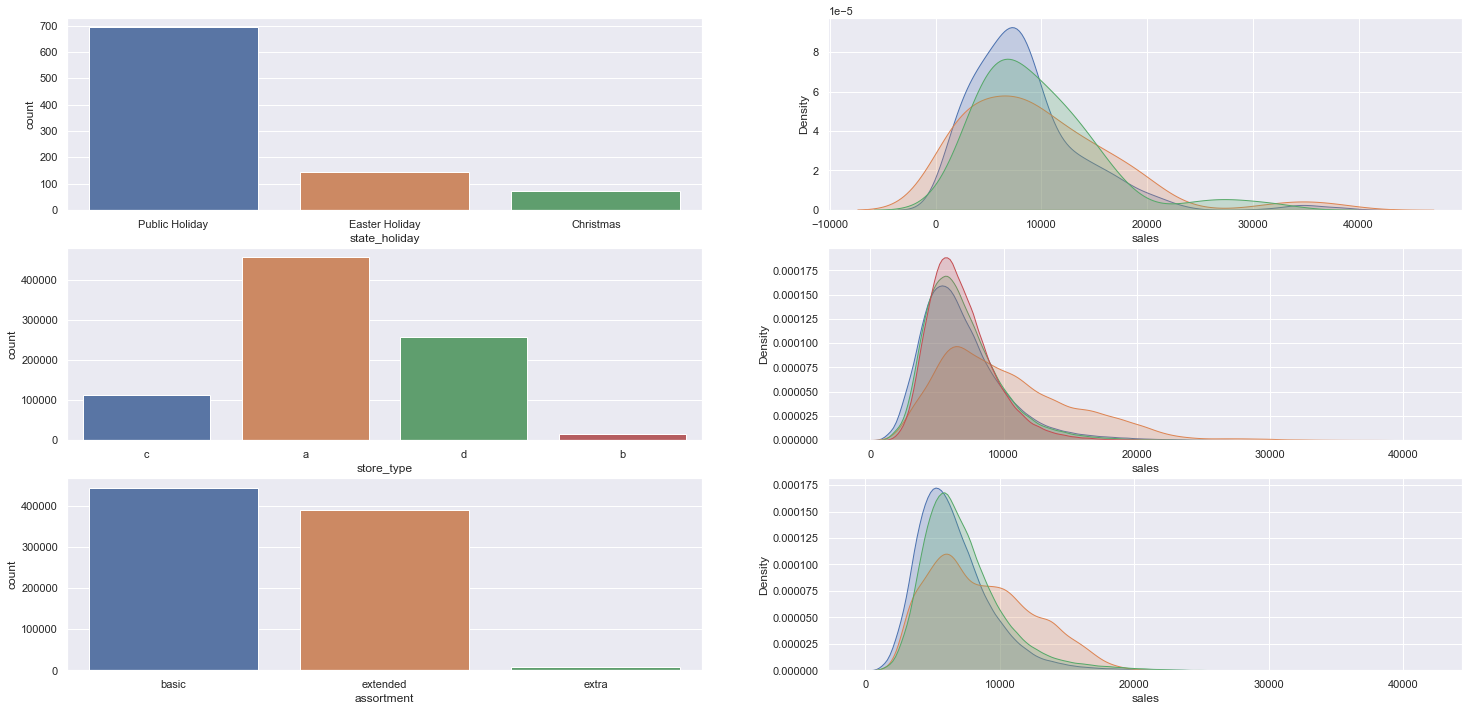

In [33]:
#state_holiday
plt.subplot( 3 ,2, 1)
others = df4[df4['state_holiday'] != 'Regular Day']
sns.countplot(data = others, x = 'state_holiday')

plt.subplot( 3 ,2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'Public Holiday']['sales'],label = 'Public Holiday', shade = True)
sns.kdeplot( df4[df4['state_holiday'] == 'Easter Holiday']['sales'],label = 'Easter Holiday', shade = True)
sns.kdeplot( df4[df4['state_holiday'] == 'Christmas']['sales'],label = 'Christmas', shade = True)

#store_type
plt.subplot( 3 ,2, 3)
sns.countplot(data = df4, x = 'store_type')

plt.subplot( 3 ,2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'],label = 'a', shade = True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'],label = 'b', shade = True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'],label = 'c', shade = True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'],label = 'd', shade = True)

#assortment
plt.subplot( 3 ,2, 5)
sns.countplot(data = df4, x = 'assortment')

plt.subplot( 3 ,2, 6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'],label = 'basic', shade = True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'],label = 'extra', shade = True)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'],label = 'extended', shade = True)

#### 4.2. Bivariate Analysis

##### H1. Lojas com maior sortimento deveriam vender mais.

<AxesSubplot:xlabel='year_week'>

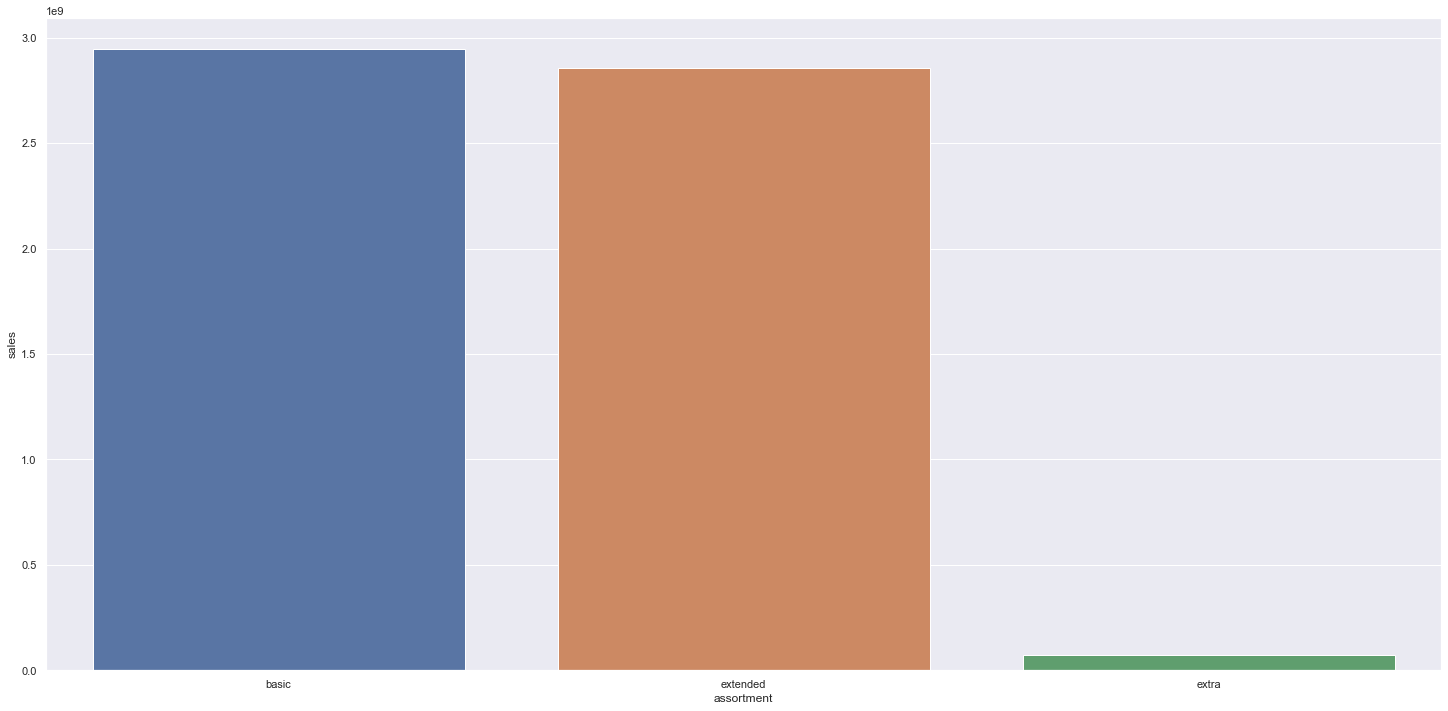

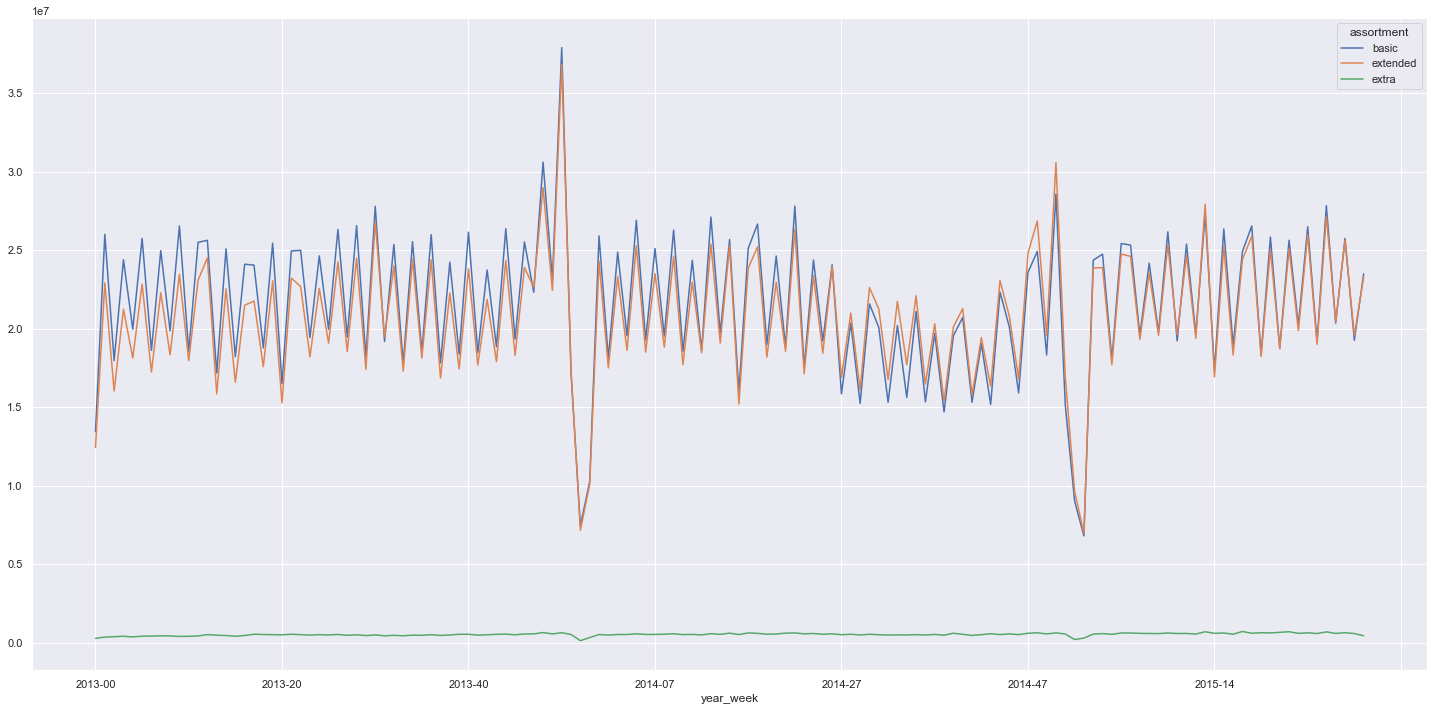

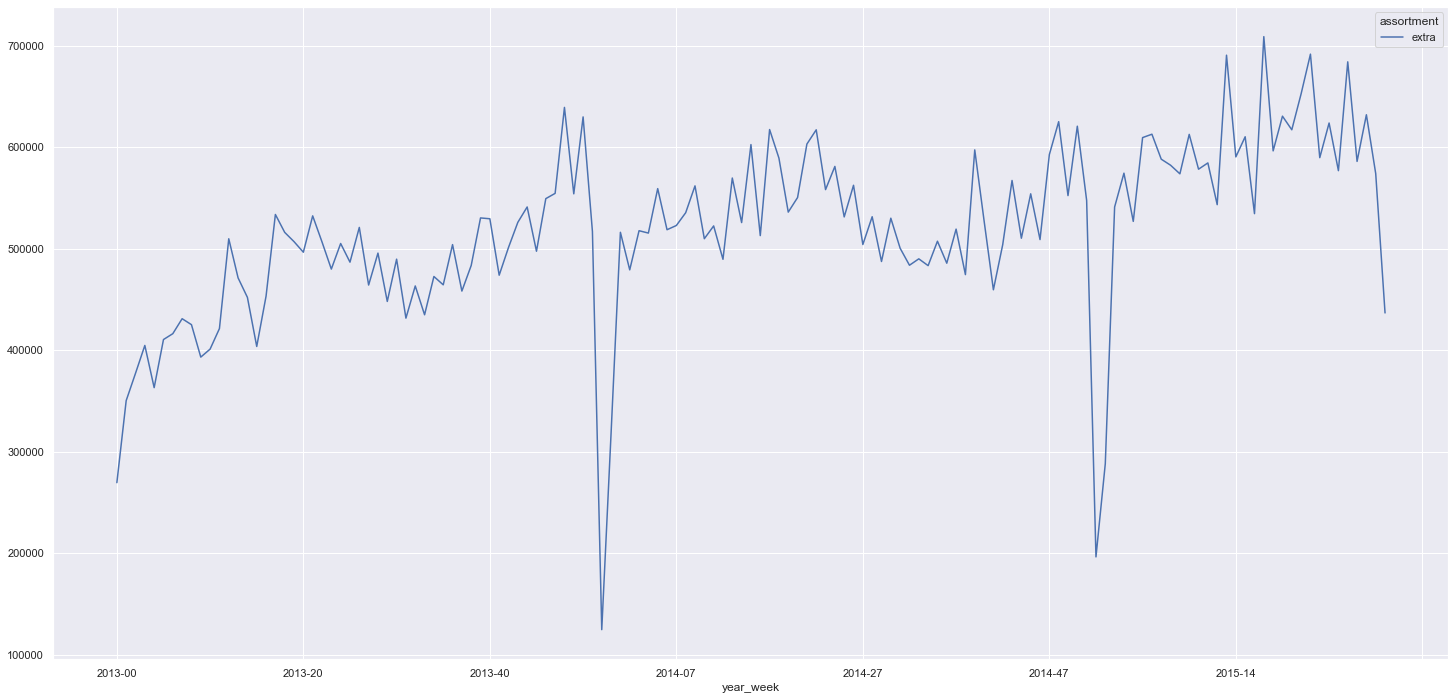

In [34]:
aux1 = df4[['assortment', 'sales']].groupby ('assortment').sum().reset_index()
sns.barplot (x = 'assortment', y = 'sales', data = aux1)

aux2 = df4[['year_week','assortment', 'sales']].groupby (['year_week','assortment']).sum().reset_index()
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

##### H2. Lojas com competidores mais próximos deveriam vender menos.

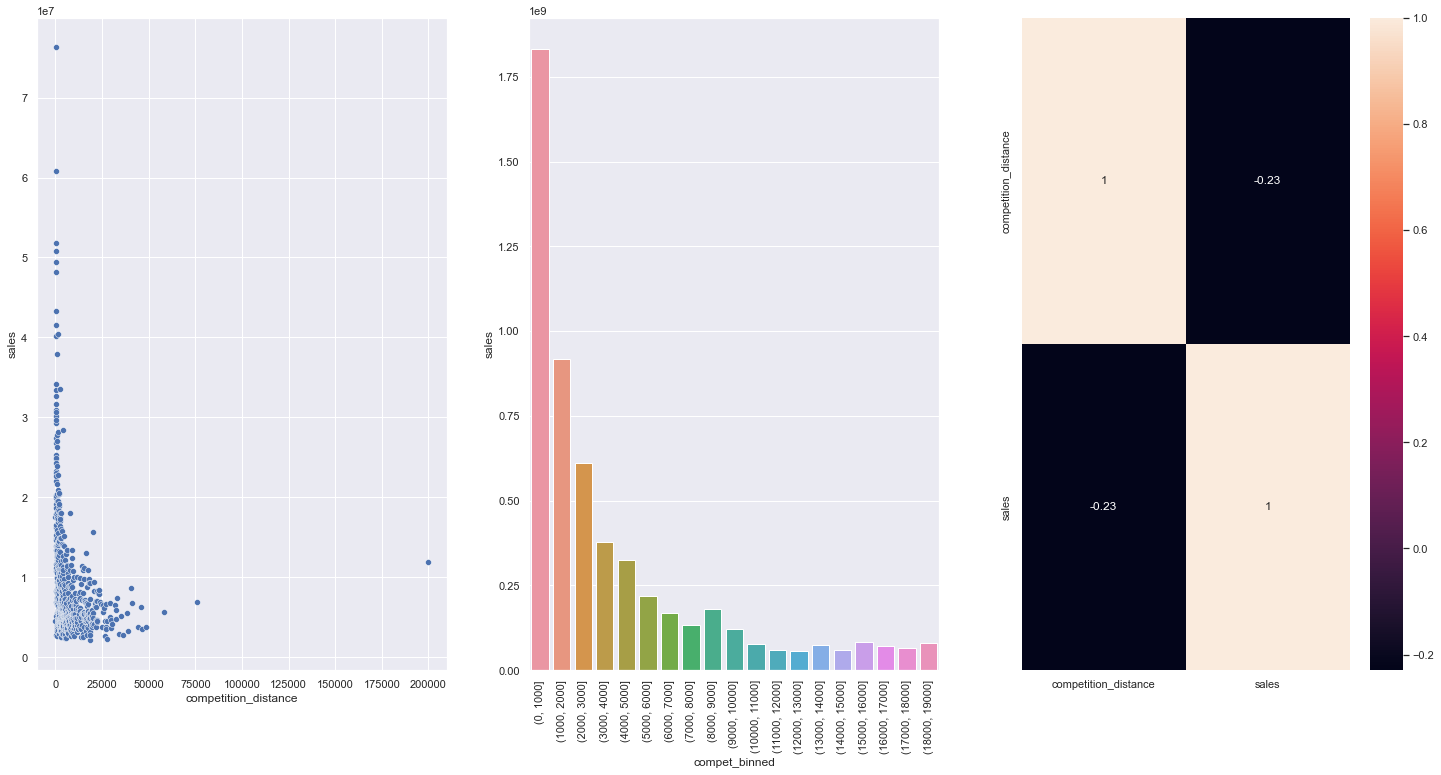

In [35]:
aux1 = df4[['competition_distance', 'sales']].groupby ('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot (x = 'competition_distance', y='sales', data = aux1)

plt.subplot(1,3,2)
bins = list(np.arange( 0, 20000, 1000))
aux1['compet_binned'] = pd.cut (aux1['competition_distance'], bins = bins)
aux2 = aux1[['compet_binned', 'sales']].groupby('compet_binned').sum().reset_index()
sns.barplot (x ='compet_binned', y = 'sales', data = aux2);
plt.xticks (rotation = 90)

plt.subplot(1,3,3)
sns.heatmap( aux1.corr (method = 'pearson'), annot = True);


##### H3. Lojas com competidores há mais tempo deveriam vender mais.

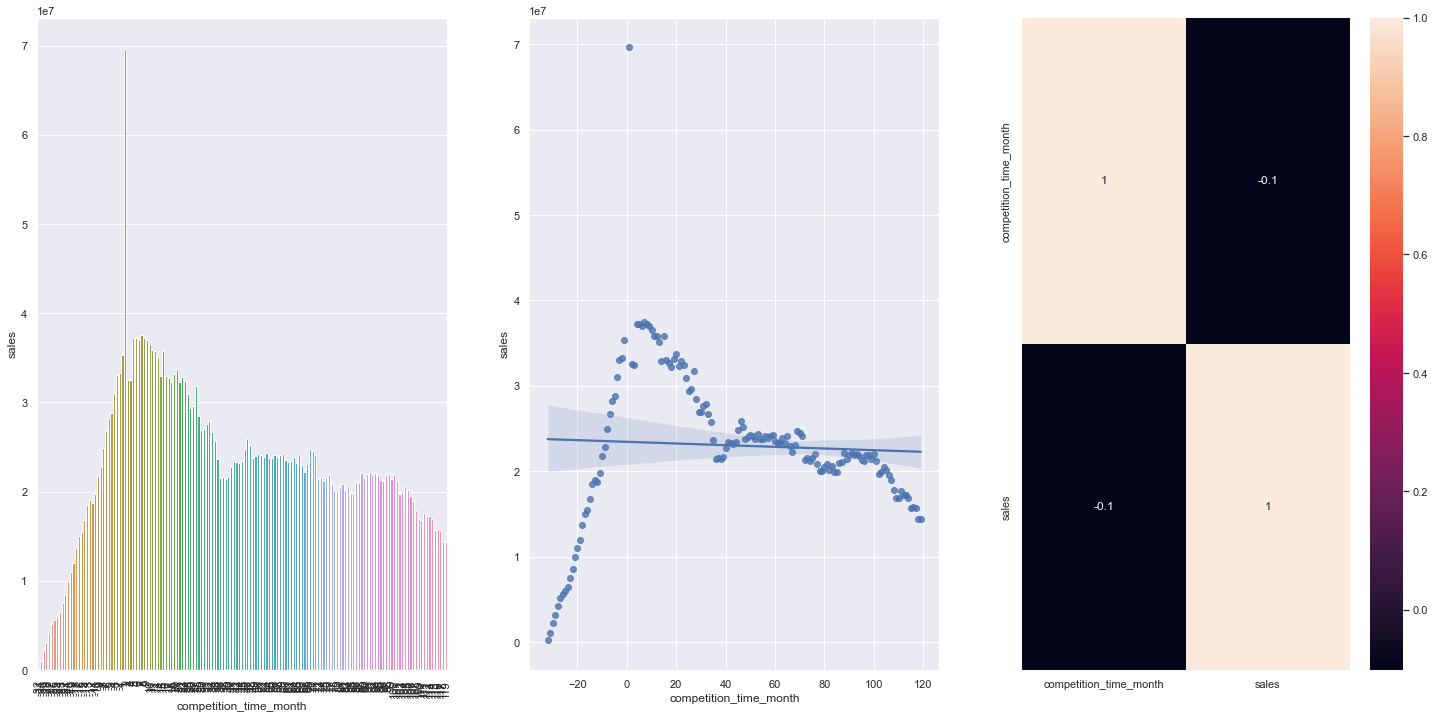

In [36]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month']< 120) & (aux1['competition_time_month']!= 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2 );
plt.xticks (rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot = True);


##### H4. Lojas com promoções ativas por mais tempo no(s) x(s) produto deveriam vender mais.

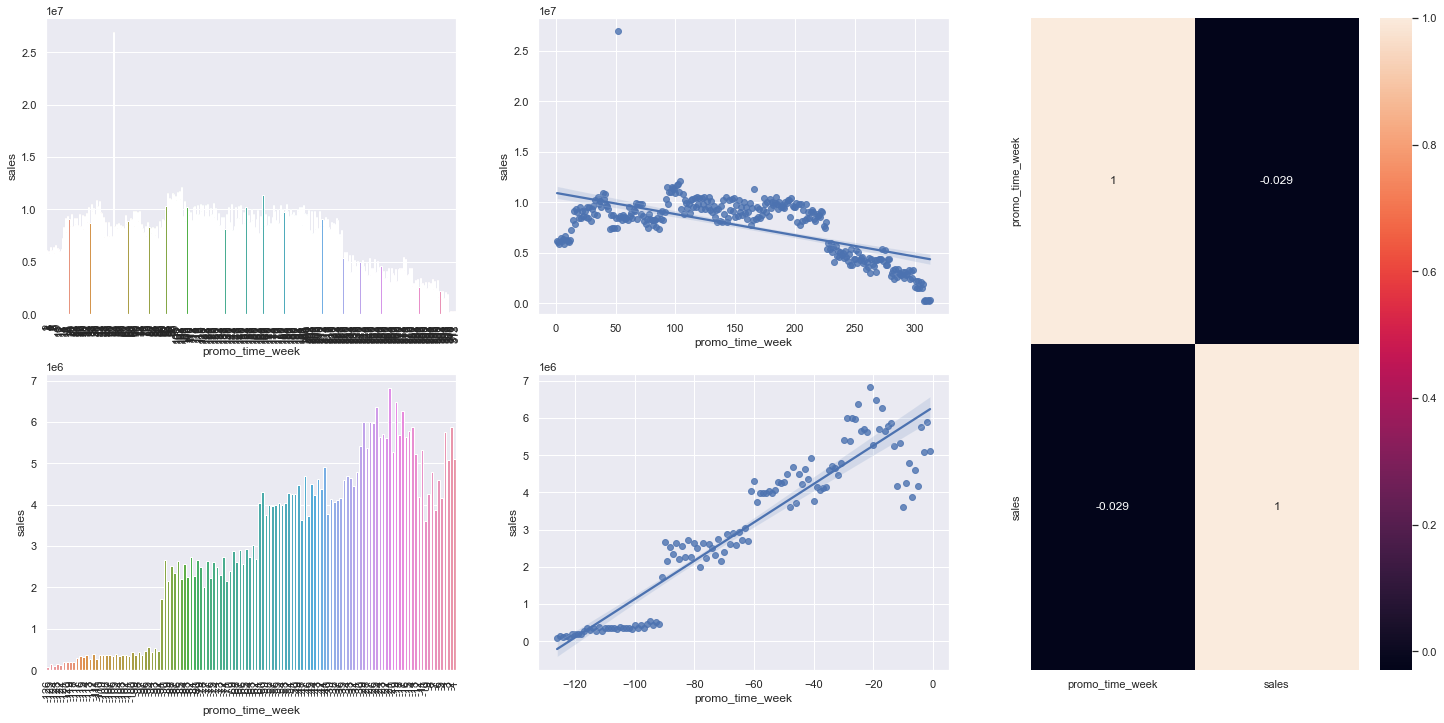

In [37]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid =  gridspec.GridSpec (2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2 );
plt.xticks (rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3 );
plt.xticks (rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3); 

plt.subplot(grid[:,2])
x = sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

##### H5. Lojas com mais dias de promoção deveriam vender mais.

##### H6. Lojas com mais promoções consecutivas deveriam vender mais.

Falsa: Lojas com mais promoções consecutivas vendem menos.

In [38]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


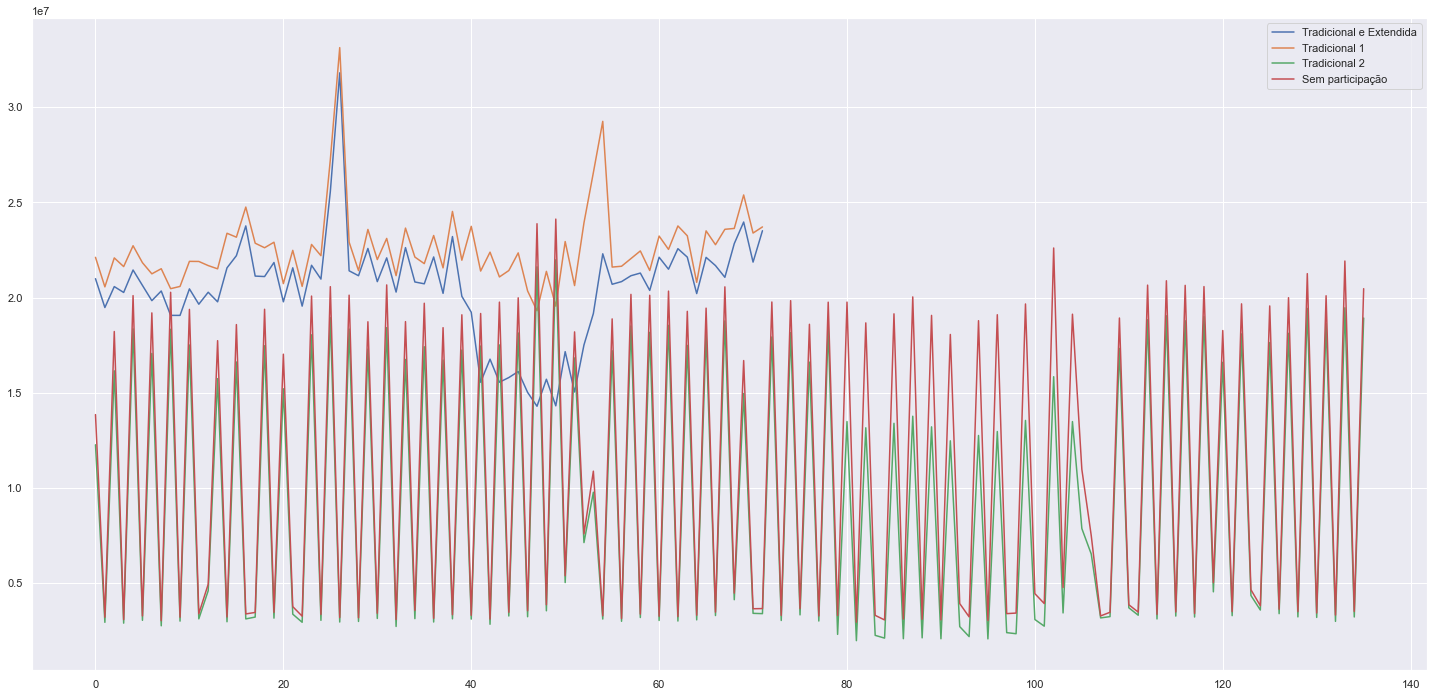

In [39]:
aux1 = df4[( df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index();
ax = aux1.plot();

aux2 = df4[( df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index();
aux2.plot(ax=ax);

aux3 = df4[( df4['promo'] == 0) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index();
aux3.plot(ax=ax);

aux4 = df4[( df4['promo'] == 0) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index();
aux4.plot(ax=ax);
ax.legend( labels = ['Tradicional e Extendida', 'Tradicional 1', 'Tradicional 2', 'Sem participação']);

##### H7. Lojas que abrem no feriado do Natal deveriam vender mais.
Falsa. Lojas abertas durante o Natal não vendem mais.

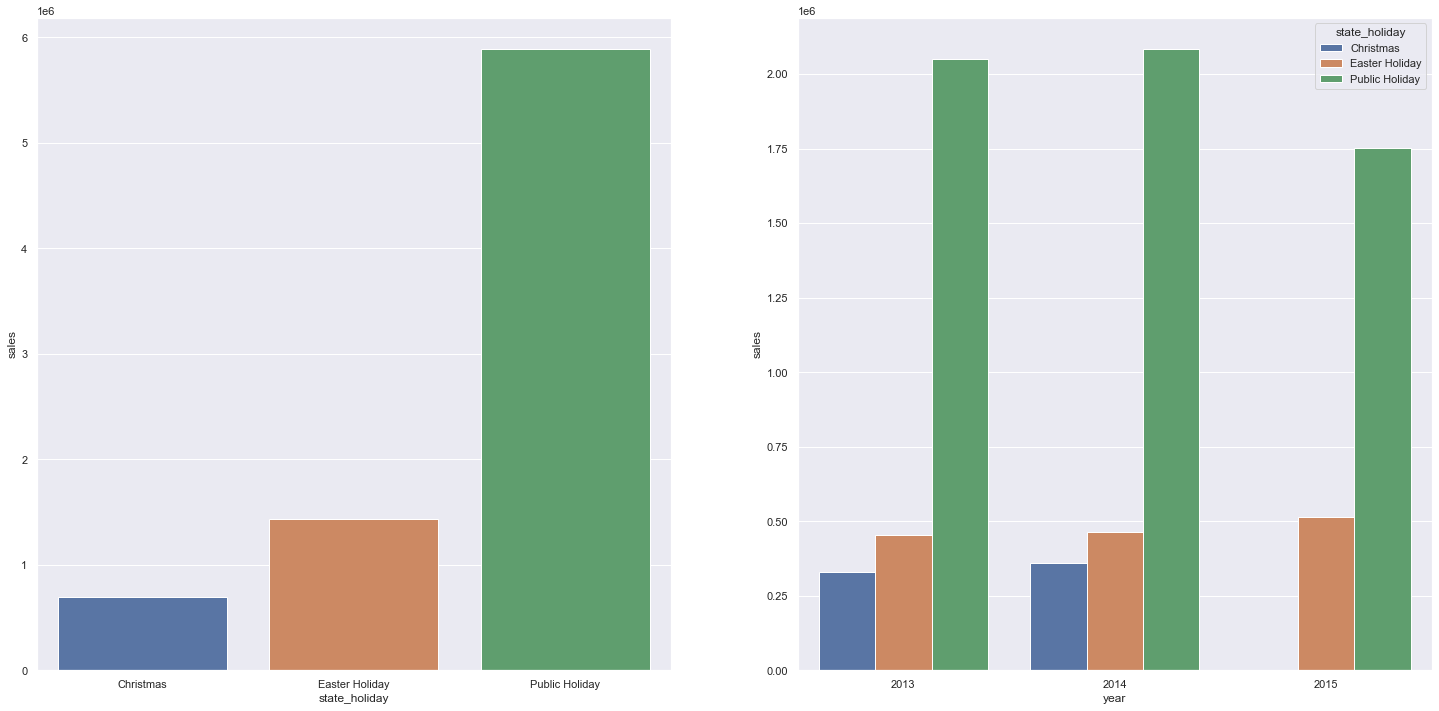

In [40]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'Regular Day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1 );


#Já vendeu mais algum dia?
plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2 );

##### H8. Lojas deveriam vender mais no decorrer dos anos.
Falsa: Lojas vendem menos no decorrer dos anos.

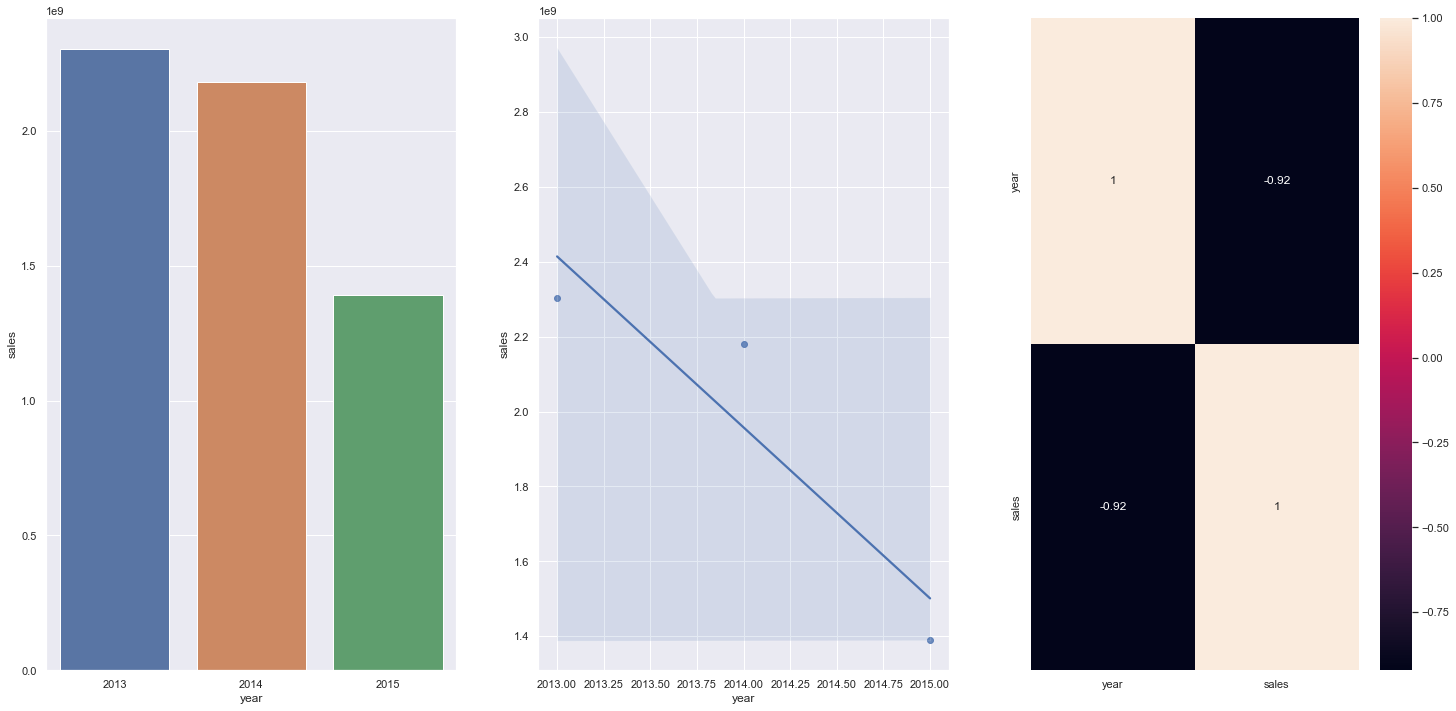

In [41]:
plt.subplot(1,3,1)
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux1 );

plt.subplot(1,3,2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

##### H9. Lojas no segundo semestre vendem mais.
Falsa: Lojas no segundo semestre vendem menos.

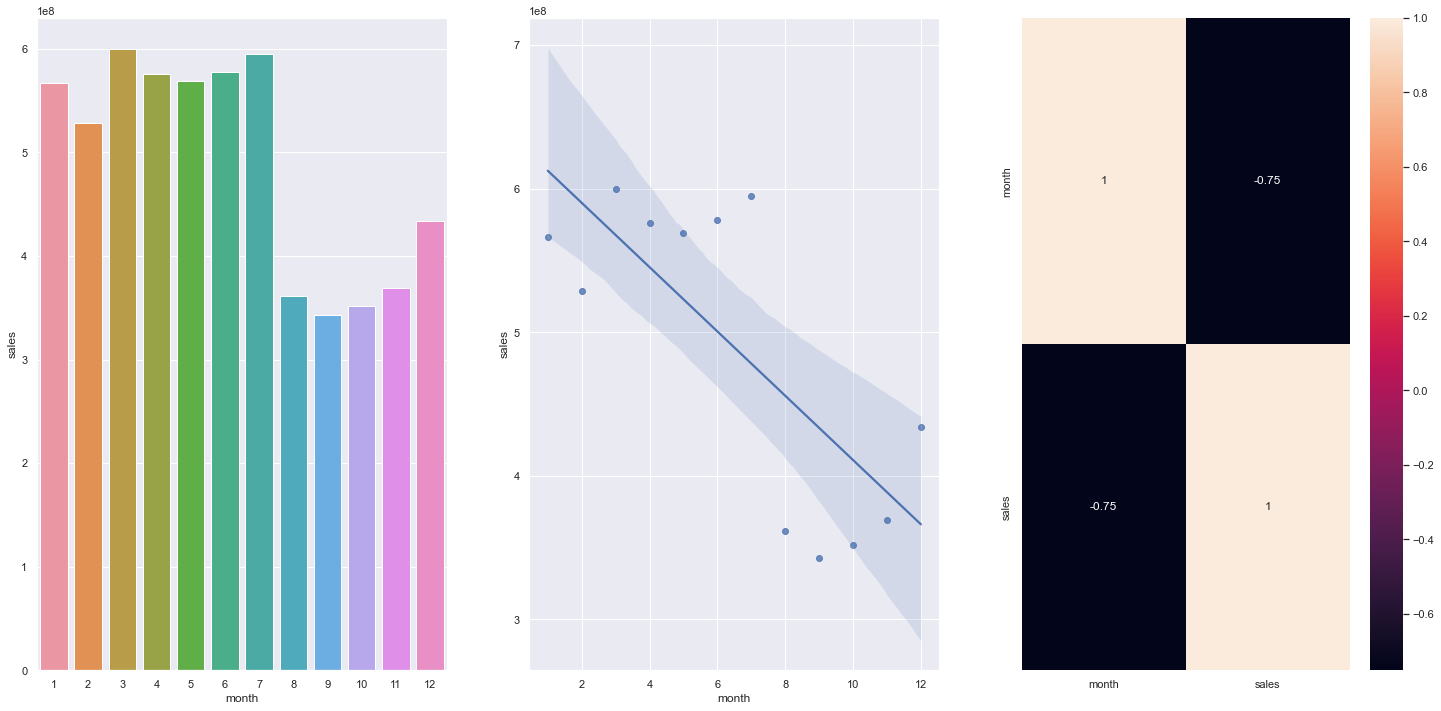

In [42]:
plt.subplot(1,3,1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x = 'month', y = 'sales', data = aux1 );

plt.subplot(1,3,2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

##### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
Verdadeira.

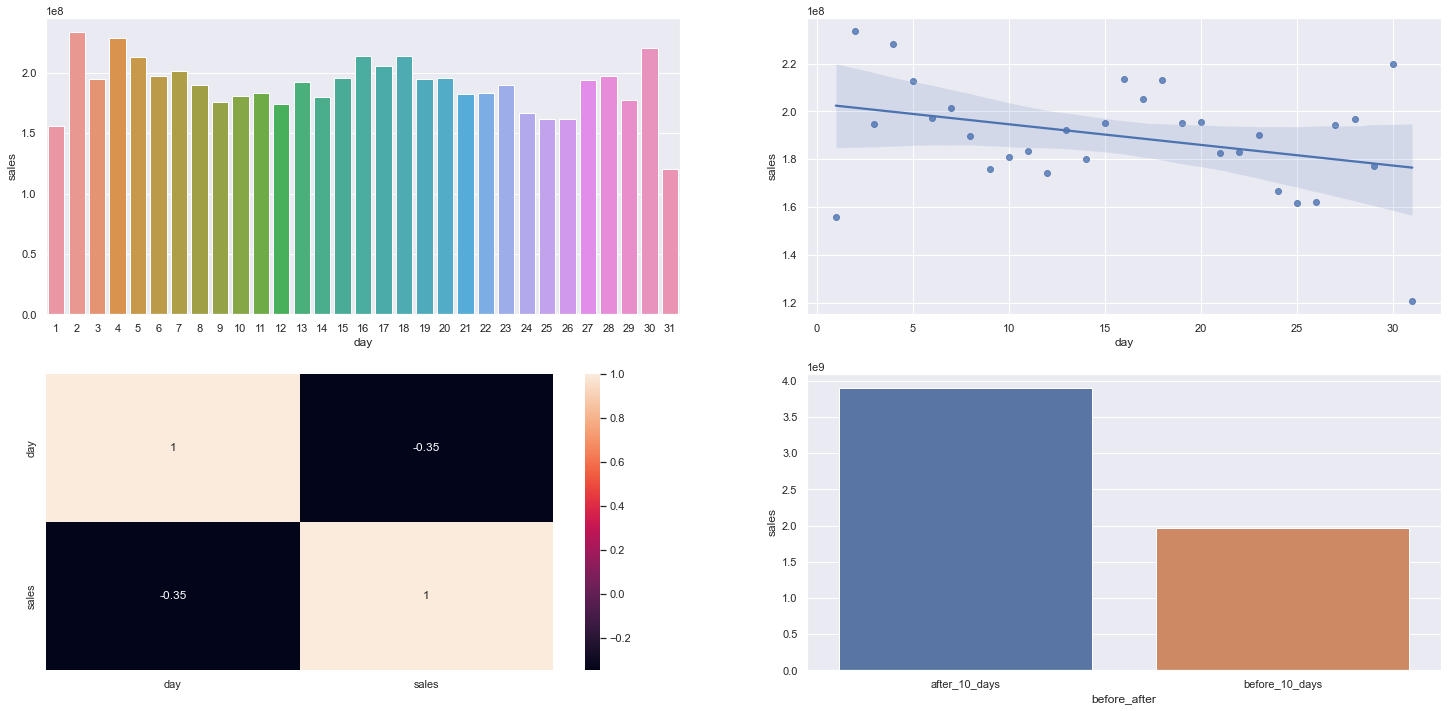

In [43]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = aux1 );

plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,3)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot( x = 'before_after', y = 'sales', data = aux2);

##### H11. Lojas que abrem nos finais de semanas deveriam vender menos.
Verdadeira.

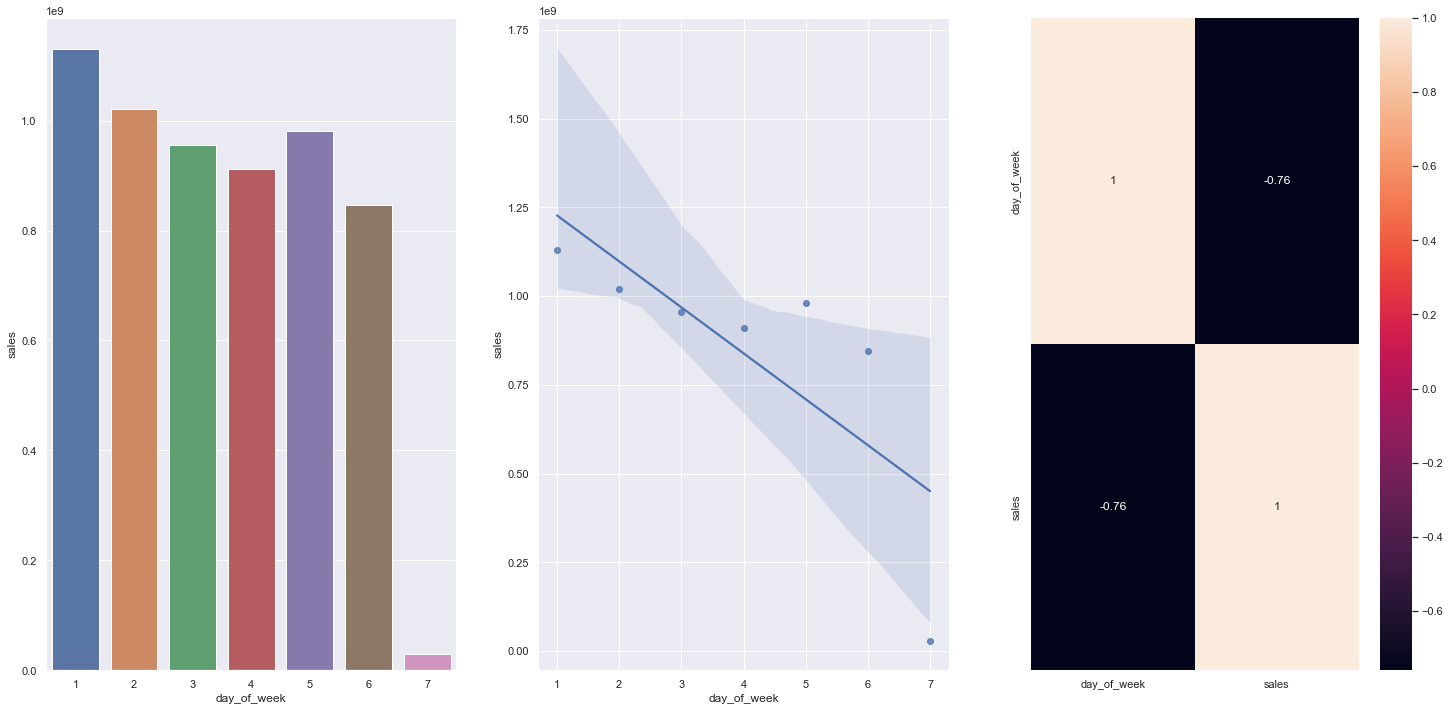

In [44]:
plt.subplot(1,3,1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1 );

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

##### H12. Lojas deveriam vender menos durante os feriados escolares.
Verdadeira, exceto nos meses de Julho e Agosto.

<AxesSubplot:xlabel='month', ylabel='sales'>

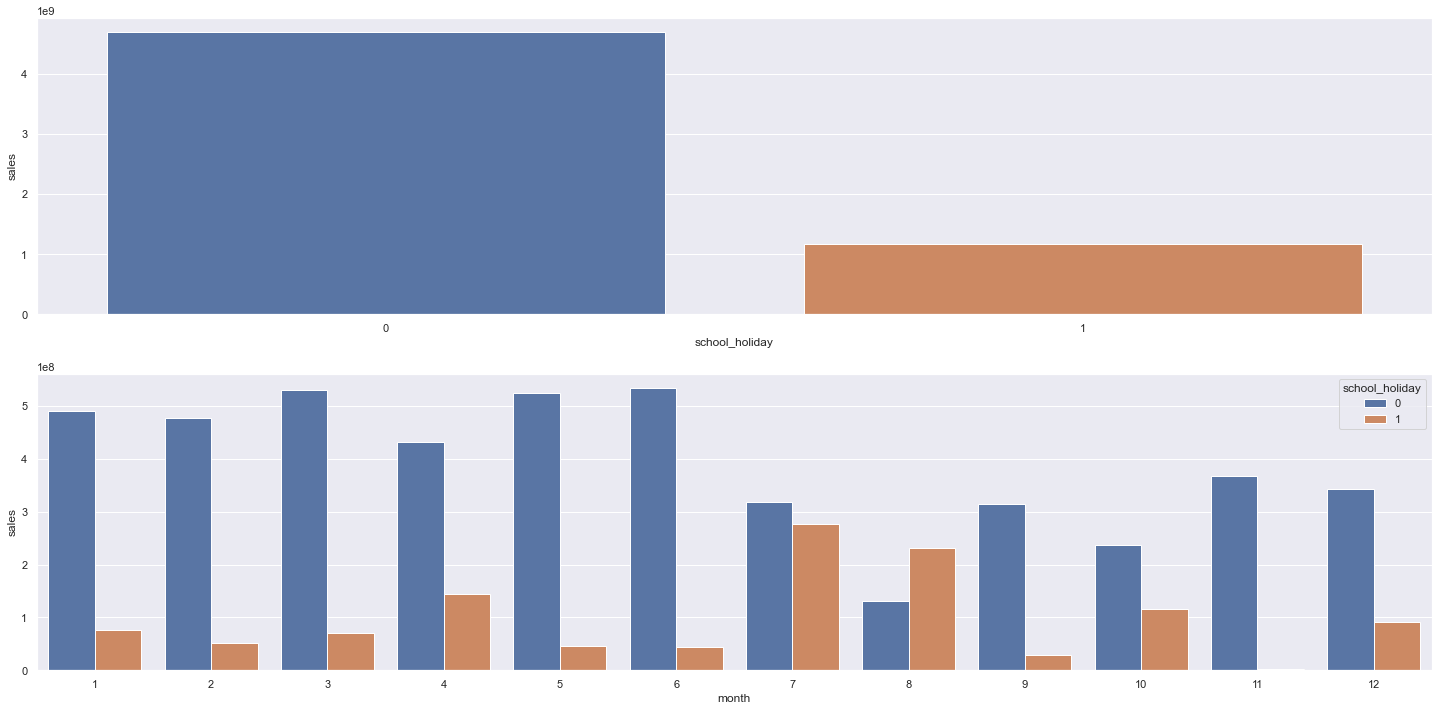

In [45]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1 );

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2 )


In [46]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


#### 4.3. Análise Multivariada

#### 4.3.1 Numerical Variable

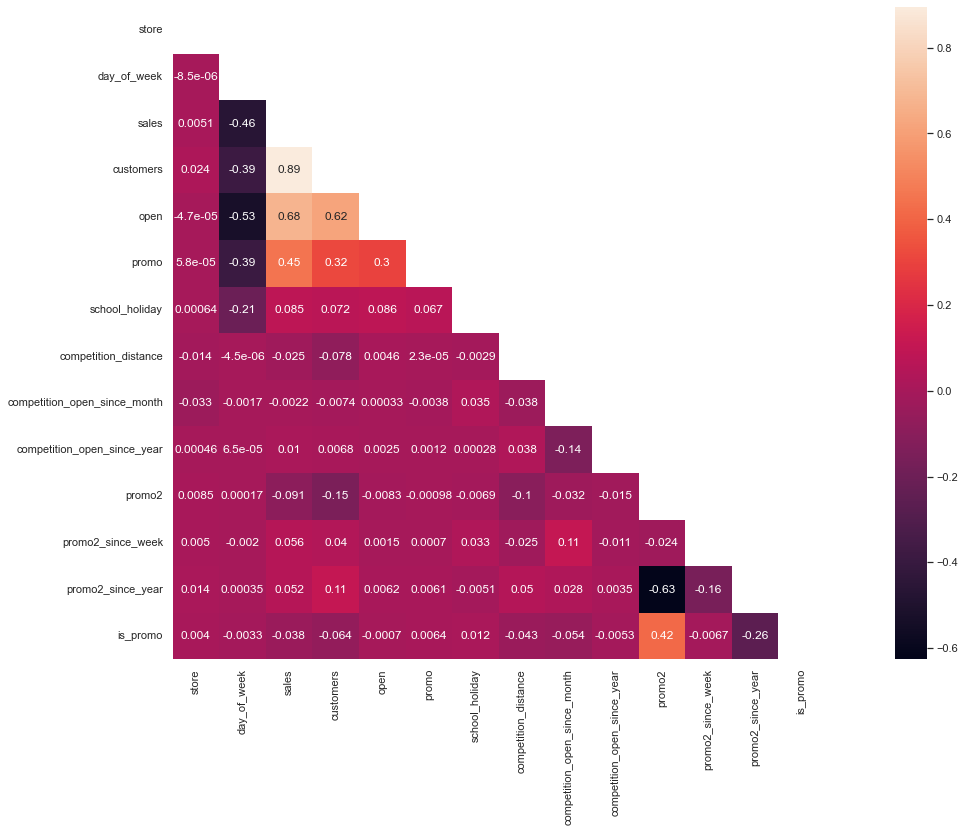

In [47]:
corr = num_attributes.corr( method = 'pearson')

mask = np.zeros_like(corr)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):

    ax = sns.heatmap(corr, mask=mask, square=True, annot = True)

#### 4.3.2 Categorical Variable

In [48]:
a = df4.select_dtypes ('object')

In [49]:
a.head()

,state_holiday,store_type,assortment,year_week
0,Regular Day,c,basic,2015-30
1,Regular Day,a,basic,2015-30
2,Regular Day,a,basic,2015-30
3,Regular Day,c,extended,2015-30
4,Regular Day,a,basic,2015-30


<AxesSubplot:>

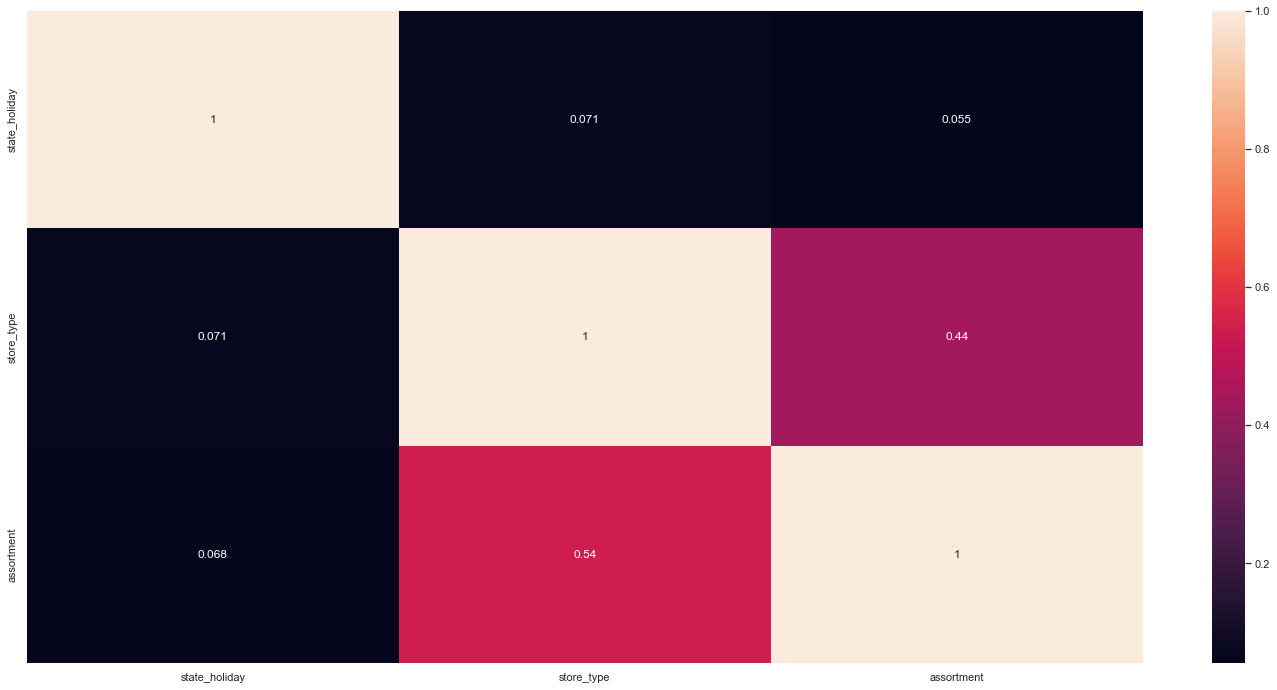

In [50]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday' : [a1,a2,a3],
              'store_type' : [a4,a5,a6],
              'assortment' : [a7,a8,a9]}) 

d = d.set_index( d.columns)

sns.heatmap(d, annot = True)

### 5.0. Data Preparation

In [51]:
df5 = df4.copy()

#### 5.1. Rescaling

In [52]:
a = df5.select_dtypes( include = ['int64', 'float64'])

In [53]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


In [54]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance

df5['competition_distance']  = rs.fit_transform ( df5[['competition_distance']].values)
pickle.dump (rs, open('/Users/marin/repos/Projeto01/parameter/competition_distance_scaler.pkl', 'wb'))

#year
df5['year'] = mms.fit_transform (df5[['year']].values)
pickle.dump (mms, open('/Users/marin/repos/Projeto01/parameter/year_scaler.pkl', 'wb'))

#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump (rs, open('/Users/marin/repos/Projeto01/parameter/competition_time_month_scaler.pkl', 'wb'))
             
#promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5 [['promo_time_week']].values)
pickle.dump (rs, open('/Users/marin/repos/Projeto01/parameter/promo_time_week_scaler.pkl', 'wb'))


In [55]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   store                         844338 non-null  int64         
 1   day_of_week                   844338 non-null  int64         
 2   date                          844338 non-null  datetime64[ns]
 3   sales                         844338 non-null  int64         
 4   promo                         844338 non-null  int64         
 5   state_holiday                 844338 non-null  object        
 6   school_holiday                844338 non-null  int64         
 7   store_type                    844338 non-null  object        
 8   assortment                    844338 non-null  object        
 9   competition_distance          844338 non-null  float64       
 10  competition_open_since_month  844338 non-null  int64         
 11  competition_

#### 5.2. Transformação

#### 5.2.1 Encoding

In [56]:
#state_holiday - One Hot Encoding

df5 = pd.get_dummies( df5, prefix =['state_holiday'], columns = ['state_holiday'])

#store_type - Label Encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform (df5['store_type'])
pickle.dump (le, open('/Users/marin/repos/Projeto01/parameter/store_type_scaler.pkl', 'wb'))

#assortment = Ordinal Enconding

assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 5.2.1 Response Variable Transformation

In [57]:
df5['sales'] = np.log1p(df5['sales'])

#### 5.2.2 Nature Transformation

In [58]:
#day_of_week

df5['day_of_week_sin'] = df5['day_of_week'].apply (lambda x: np.sin (x *(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply (lambda x: np.cos (x *(2*np.pi/7)))

#month

df5['month_sin'] = df5['month'].apply (lambda x: np.sin (x *(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply (lambda x: np.cos (x *(2*np.pi/12)))

#day

df5['day_sin'] = df5['day'].apply (lambda x: np.sin (x *(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply (lambda x: np.cos (x *(2*np.pi/30)))

#week_of_year

df5['week_of_year_sin'] = df5['week_of_year'].apply (lambda x: np.sin (x *(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply (lambda x: np.cos (x *(2*np.pi/52)))

### 6.0. Feature Selection

In [59]:
df6 = df5.copy()

In [60]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_Christmas,state_holiday_Easter Holiday,state_holiday_Public Holiday,state_holiday_Regular Day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


#### 6.1. Split DataFrame into Training and Test DataSet

In [61]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [62]:
df6[['store','date']].groupby('store').min().reset_index()['date'][0]

Timestamp('2013-01-02 00:00:00')

In [63]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [64]:
#Training
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


#### 6.2. Boruta as Feature Selector

In [65]:
## Training and Test DataSet Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

## Define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

## Define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )

## Best Features
#cols_selected = boruta.support_.tolist()
#X_train_fs = X_train.drop ( [ 'date', 'sales'], axis = 1 )
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

#### 6.3. Manual Feature Selection

In [66]:
cols_not_selected_boruta = [
 'is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_Christmas',
 'state_holiday_Easter Holiday',
 'state_holiday_Public Holiday',
 'state_holiday_Regular Day',
 'week_of_year_sin',
 'year']

In [67]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [68]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'month_sin',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos' ]

feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

### 7.0. Machine Learning Modelling

In [69]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

#### 7.1. Average Model

In [70]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales':'predictions'})
aux1 = pd.merge (aux1, aux2, how='left', on = 'store')
yhat_baseline = aux1['predictions']

baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


#### 7.2. Linear Regression Model

In [71]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error ('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


#### 7.2.1. Linear Regression Model - Cross Validation

In [72]:
lr_result_cv = cross_validation (x_training, 5, 'LinearRegression', lr, verbose = False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


#### 7.3. Linear Regression Regularized Model - Lasso

#### 7.3.1. Lasso - Cross Validation

In [73]:
# Model
lrr = Lasso( alpha = 0.01).fit(x_train, y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error ('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


In [74]:
lrr_result_cv = cross_validation (x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


#### 7.4. Random Forest Regressor

#### 7.4.1. Random Forest - Cross Validation

In [75]:
# Model
rf = RandomForestRegressor( n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error ('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.741952,0.099839,1009.225168


In [76]:
rf_result_cv = cross_validation (x_training, 5, 'Random Forest Regressor', rf, verbose = True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.87 +/- 218.78,0.12 +/- 0.02,1257.07 +/- 319.77


#### 7.5. XGBoost Regressor

#### 7.5.1. XGBoost Regressor - Cross Validation

In [77]:
# Model
model_xgb = xgb.XGBRegressor().fit(x_train, y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
model_xgb_result = ml_error ('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
model_xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.958205,0.130309,1238.550843


In [78]:
xgb_result_cv = cross_validation (x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1063.51 +/- 178.21,0.15 +/- 0.02,1518.89 +/- 241.61


#### 7.6. Model's Performance

#### 7.6.1 Single Model's Performance

In [79]:
modelling_result = pd.concat ([baseline_result, lr_result, lrr_result, rf_result, model_xgb_result])
modelling_result.sort_values ('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.741952,0.099839,1009.225168
0,XGBoost Regressor,868.958205,0.130309,1238.550843
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


#### 7.6.2 Real Model's Performance - CV

In [80]:
modelling_result_cv = pd.concat ([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,837.87 +/- 218.78,0.12 +/- 0.02,1257.07 +/- 319.77
0,XGBoost Regressor,1063.51 +/- 178.21,0.15 +/- 0.02,1518.89 +/- 241.61


#### 8.0 - Hyperparameter Fine Tuning

#### 8.1 Random Search

In [81]:
#param = {  'n_estimators': [1500,1700,2500,3000,3500],
#          'eta': [0.01, 0.03],
#           'max_depth': [3,5,9],
#           'subsample': [0.1,0.5,0.7],
#           'colsample_bytree': [0.3,0.7,0.9],
#          'min_child_weight': [3,8,15]    }

#MAX_EVAL = 5

In [82]:
#final_result = pd.DataFrame()
#
#for i in range(MAX_EVAL):
#    # Choose values for parameters randomly
#    hp = {k: random.sample(v,1)[0]for k,v in param.items()}
#    print(hp)
#    # Model
#    model_xgb = xgb.XGBRegressor(n_estimators = hp['n_estimators'],
#                                                eta = hp['eta'],
#                                                max_depth = hp['max_depth'],
#                                                subsample = hp['subsample'],
#                                                colsample_bytree = hp['colsample_bytree'],
#                                                min_child_weight = hp['min_child_weight'])

    
#    # Performance
#    result = cross_validation (x_training, 5, 'XGBoost Regressor', model_xgb)
#    final_result = pd.concat ([final_result, result])

#final_result

#### 8.2 Final Model

In [83]:
param_tuned = {'n_estimators': 3000 ,
         'eta': 0.03,
         'max_depth': 5 ,
         'subsample': 0.7,
         'colsample_bytree': 0.7 ,
         'min_child_weight': 3}

In [84]:
# Model
model_xgb_tuned = xgb.XGBRegressor(n_estimators = param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree = param_tuned['colsample_bytree'],
                                   min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

# Prediction

yhat_xgb_tuned = model_xgb_tuned.predict(x_test)
    
# Performance
result_xgb_tuned = ml_error ('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
result_xgb_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,765.702323,0.115405,1097.124216


In [85]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.018435318458462035

### 9.0 - Tradução e Interpretação do Erros

In [86]:
df9 = X_test[cols_selected_boruta_full]

#rescale

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

C:\Users\marin\AppData\Local\Temp/ipykernel_13936/1086728677.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1(df9['sales'])
C:\Users\marin\AppData\Local\Temp/ipykernel_13936/1086728677.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


### 9.1 - Business Performance

In [87]:
# Sum of Predictions

df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename (columns ={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename (columns ={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on = 'store')

# Scenarios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order Columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [88]:
df92.sort_values ('MAPE', ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106819.148438,103452.426051,110185.870824,3366.722386,0.588820
908,909,227656.734375,219950.262674,235363.206076,7706.471701,0.510541
169,170,210741.609375,209152.701185,212330.517565,1588.908190,0.393369
875,876,196315.828125,192210.046981,200421.609269,4105.781144,0.340104
969,970,126399.921875,125695.419041,127104.424709,704.502834,0.318918


<AxesSubplot:xlabel='store', ylabel='MAPE'>

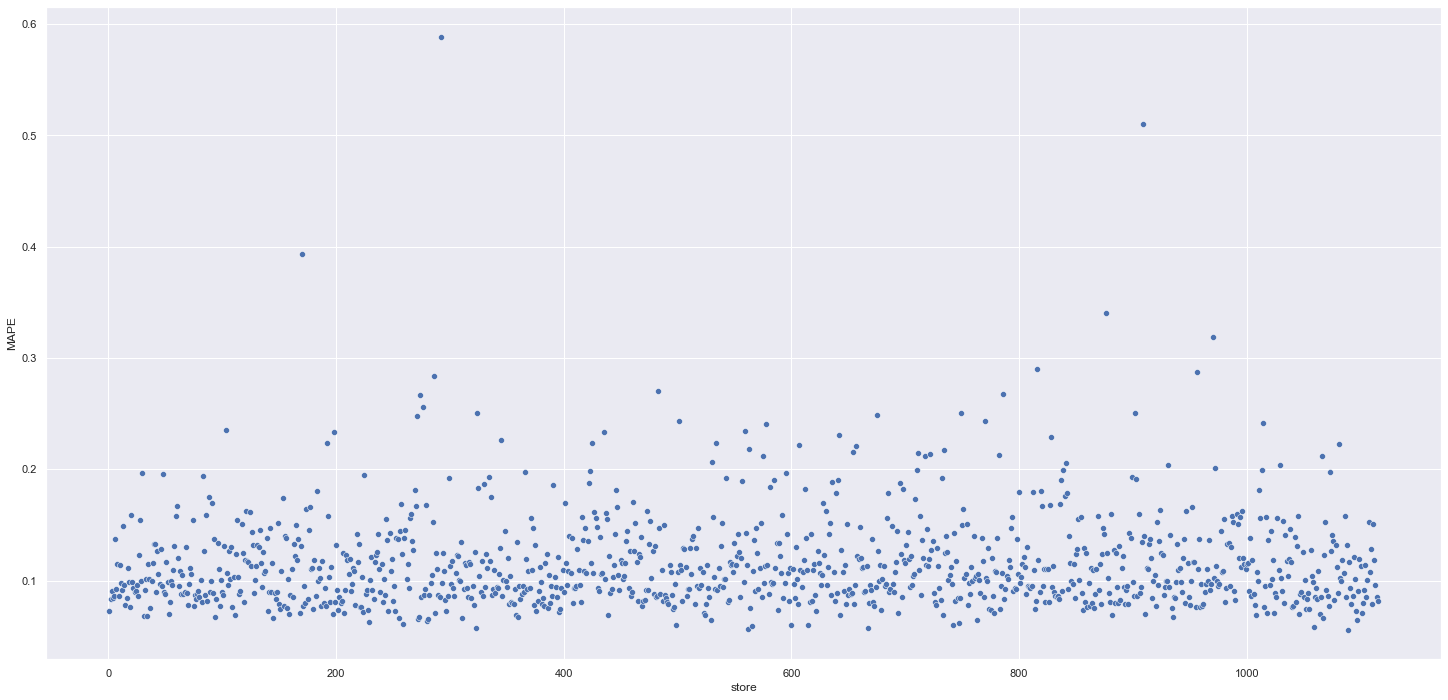

In [89]:
sns.scatterplot (x = 'store', y = 'MAPE', data = df92)

In [90]:
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
917,918,191283.015625,190824.864838,191741.166412,458.150787,0.099940
339,340,258082.812500,257483.554318,258682.070682,599.258182,0.088525
706,707,313763.718750,312923.558515,314603.878985,840.160235,0.103869
512,513,548795.937500,546484.143423,551107.731577,2311.794077,0.137358


### 9.2 - Total Performance

In [91]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename (columns = {'index': 'Scenario', 0: 'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$286,560,512.00"
1,worst_scenario,"R$285,703,538.67"
2,best_scenario,"R$287,417,443.98"


### 9.3 - Machine Learning Performance

In [92]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

C:\Users\marin\AppData\Local\Temp/ipykernel_13936/1713337479.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
C:\Users\marin\AppData\Local\Temp/ipykernel_13936/1713337479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions']/df9['sales']


C:\Users\marin\.conda\envs\Projeto01\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\marin\.conda\envs\Projeto01\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

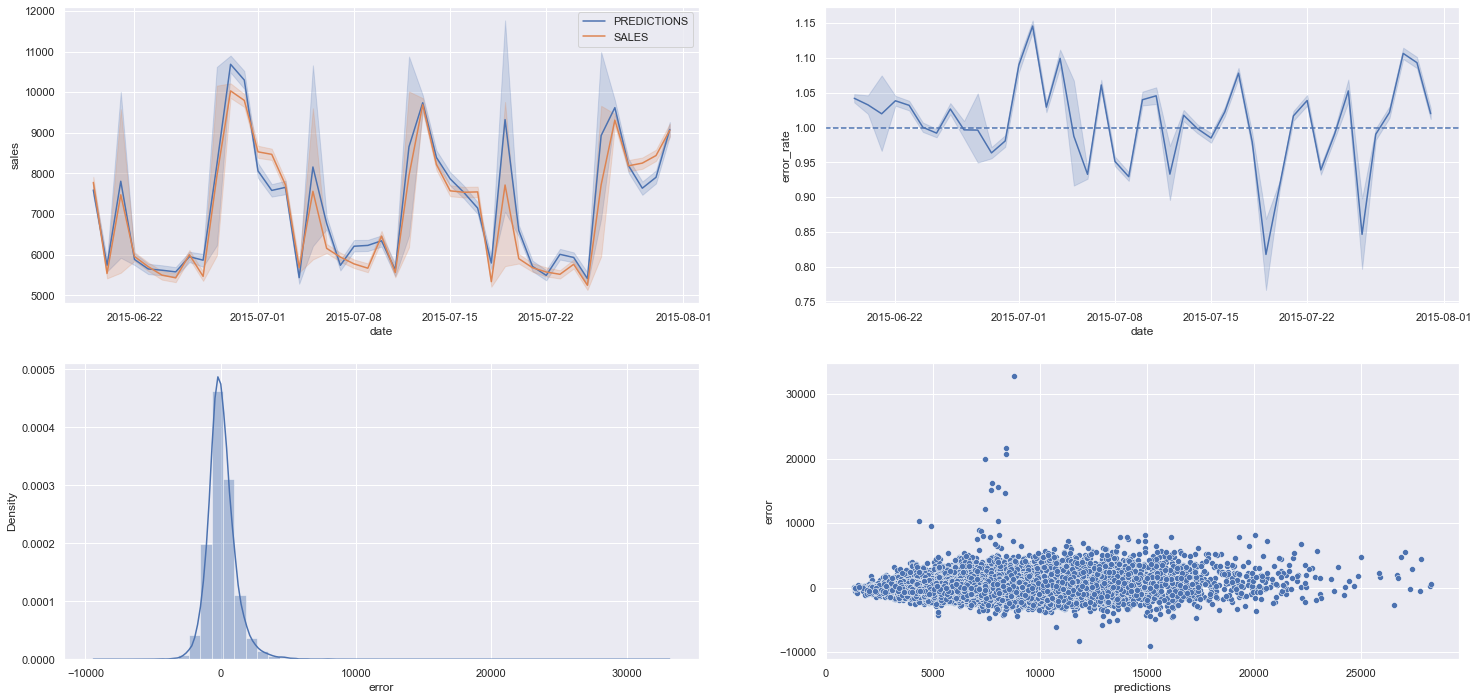

In [93]:
plt.subplot(2,2,1)
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'PREDICTIONS')
sns.lineplot(x = 'date', y = 'predictions', data  = df9, label = 'SALES')

plt.subplot(2,2,2)
sns.lineplot(x = 'date', y = 'error_rate', data = df9)
plt.axhline (1, linestyle = '--')

plt.subplot (2,2,3)
sns.distplot (df9['error'])

plt.subplot (2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])

### 10.0 - Deploy Model to Production

In [94]:
pickle.dump(model_xgb_tuned, open('/Users/marin/repos/Projeto01/model_rossmann.pkl', 'wb'))

#### 10.1 - Rossmann Class

In [95]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    
    def __init__( self ):
        self.home_path='/Users/marin/repos/Projeto01/'
        self.competition_distance_scaler = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
    
    def data_cleaning( self, df1 ):
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday','StoreType', 'Assortment', 'CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore( x )
        
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df1.columns = cols_new
        
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )
        
        ## 1.5. Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace=True )
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x:0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
        
        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1
        
    def feature_engineering( self, df2 ):

            # year
            df2['year'] = df2['date'].dt.year
            
            # month
            df2['month'] = df2['date'].dt.month
            
            # day
            df2['day'] = df2['date'].dt.day

            # week of year
            df2['week_of_year'] = df2['date'].dt.weekofyear

            # year week
            df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

            # competition since

            df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ), axis=1 )
            df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )
            
            # promo since
            
            df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
            df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
            df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
            
            # assortment
            df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
            
            # state holiday
            df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

            # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

            ## 3.1. Filtragem das Linhas

            df2 = df2[df2['open'] != 0]

            ## 3.2. Selecao das Colunas

            cols_drop = ['open', 'promo_interval', 'month_map']

            df2 = df2.drop( cols_drop, axis=1 )

            return df2

        
    def data_preparation( self, df5 ):


            ## 5.2. Rescaling

            # competition distance

            df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

            # competition time month

            df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

            # promo time week

            df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values )

            # year

            df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

            
            ### 5.3.1. Encoding

            # state_holiday - One Hot Encoding
            df5 = pd.get_dummies( df5, prefix=['state_holiday'],columns=['state_holiday'] )

            # store_type - Label Encoding
            df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'] )

            # assortment - Ordinal Encoding
            assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
            df5['assortment'] = df5['assortment'].map( assortment_dict )

            ### 5.3.3. Nature Transformation

            # day of week

            df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x* ( 2. * np.pi/7 ) ) )
            df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x* ( 2. * np.pi/7 ) ) )

            # month

            df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )

            df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

            # day


            df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )

            df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

            # week of year

            df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin(x * ( 2. * np.pi/52 ) ) )

            df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos(x * ( 2. * np.pi/52 ) ) )

            cols_selected = [ 'store', 'promo', 'store_type', 'assortment','competition_distance', 'competition_open_since_month','competition_open_since_year', 'promo2', 'promo2_since_week','promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos','day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']

            return df5[ cols_selected ]

    def get_prediction( self, model, original_data, test_data ):

            # prediction

            pred = model.predict( test_data )

            # join pred into the original data

            original_data['prediction'] = np.expm1( pred )

            return original_data.to_json( orient='records', date_format='iso' )

#### 10.2 - API Handler

In [136]:
import pickle
import pandas as pd
from flask            import Flask, request, Response
from rossmann.Rossmann import Rossmann

model = pickle.load(open( '/Users/marin/repos/Projeto01/model_rossman.pkl', 'rb'))

app = Flask( __name__)

@app.route( '/rossmann/predict', methods = ['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index = [0])
        else:
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
        
        pipeline = Rossmann()
        
        df1 = pipeline.data_cleaning(test_raw)
        
        df2 = pipeline.feature.engineering (df1)
        
        df3 = pipeline.data_preparation (df2)
        
        df_response = pipeline.get_predicition(model, test_raw, df3)
        
        return df_responde
        
    else:  
        return Response('{}', status = 200, mimetype = 'application/json')
    
    

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

#### 10.3 - API Tester

In [122]:
import json
import pandas as pd
import requests

In [123]:
df10 = pd.read_csv('/Users/marin/repos/Projeto01/code/test.csv')

In [137]:
df_test = pd.merge (df10, df_store_raw, how = 'left', on = 'Store')

df_test = df_test[df_test['Store'] == 22]

df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis = 1)

In [138]:
data = json.dumps(df_test.to_dict ( orient = 'records'))

In [144]:
url = 'https://rossmann-pred-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data = data, headers = header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [140]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [141]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,5219.196289
1,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,5312.888672
2,22,2,2015-09-15T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,15,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,6181.352051
3,22,1,2015-09-14T00:00:00.000Z,1.0,1,regular_day,1,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,14,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,6872.018066
4,22,6,2015-09-12T00:00:00.000Z,1.0,0,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,12,37,2015-36,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,172,3049.904297


In [143]:
d2 = d1[['store', 'prediction']].groupby( 'store').sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )

Store Number 22 will sell R$171,247.17 in the next 6 weeks
